In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM,GRU

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#importo il dataset
df=pd.read_csv("/home/davide/Scaricati/time_series_dataset.csv",sep=";",index_col=['Data'],parse_dates = ['Data'])

In [3]:
#suddivido il dataset in train e validation set

train_set=df['2010-01-01':'2017-12-31']
validation_set=df['2018-01-01':'2018-12-31']

In [4]:
#prendo i valori di train e validation set
train_time_series=train_set["value"]
val_time_series=validation_set["value"]

### MODELLO SARIMA

In [5]:
#definisco una funzione per controllare la stazionarietà in varianza della serie
def check_variance_stationarity(time_series,window):
    return time_series[:window].var(),time_series[window:].var()

In [6]:
#definisco una funzione per controllare la stazionarietà in media della serie
def check_mean_stationarity(time_series,window):
    return time_series[:window].mean(),time_series[window:].mean()

In [7]:
#controllo la stazionarietà in media e in varianza della serie originale; non è stazionaria (in senso debole),
#perciò applico la trasformazione logaritmica

w_1_var,w_2_var=check_variance_stationarity(train_time_series,round(len(train_time_series)/2))
w_1_mean,w_2_mean=check_mean_stationarity(train_time_series,round(len(train_time_series)/2))

print("Varianza: ",w_1_var, w_2_var)
print("Media: ",w_1_mean,w_2_mean)

Varianza:  669.8806741308458 557.2431147417415
Media:  134.5544516276523 97.06338990965092


In [8]:
#trasformo la serie usando il logaritmo

log_train_time_series=np.log(train_time_series)
log_val_time_series=np.log(val_time_series)

In [9]:
#la trasformazione logaritmica sistema (in parte) la stazionarietà debole, rendendo quasi costante nel tempo sia 
#la media che la varianza

w_1_log_var,w_2_log_var=check_variance_stationarity(log_train_time_series,round(len(log_train_time_series)/2))
w_1_log_mean,w_2_log_mean=check_mean_stationarity(log_train_time_series,round(len(log_train_time_series)/2))

print("Varianza: ",w_1_log_var, w_2_log_var)
print("Media: ",w_1_log_mean,w_2_log_mean)

Varianza:  0.04834405690979603 0.06086737147651746
Media:  4.880463477486453 4.545767363910194


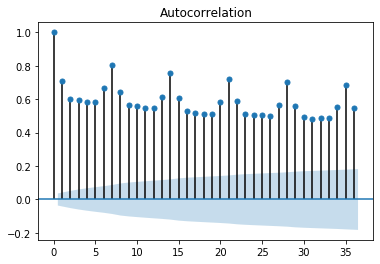

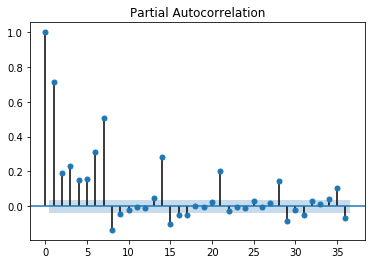

In [10]:
#operando sulla serie logaritmica, vengono plottati ACF e PACF 

plot_acf(log_train_time_series,lags=36)
plot_pacf(log_train_time_series,lags=36)
plt.show()

In [11]:
#il modello SARIMA finale ha 2 lags non staginali e una differenza stagionale con periodo 7; guardando ACF e PACF
#dei residui si è aggiunto un ordine di moving average sia alla parte stagionale che a quella non stagionale

model_sarima=SARIMAX(log_train_time_series,order=(2,0,1),seasonal_order=(0,1,1,7),enforce_stationarity=False,
             enforce_invertibility=False)

model_sarima_fit=model_sarima.fit(disp=False)

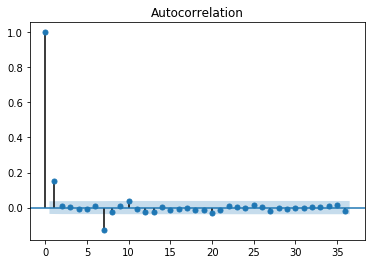

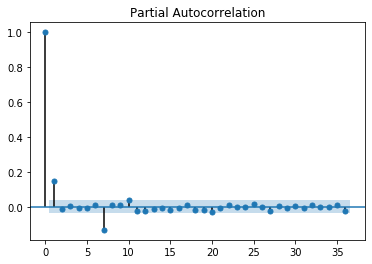

In [12]:
#dai grafici si può notare come questo modello finale colga più o meno tutta l'autocorrelazione dei residui
plot_acf(model_sarima_fit.resid,lags=36)
plot_pacf(model_sarima_fit.resid,lags=36)
plt.show()

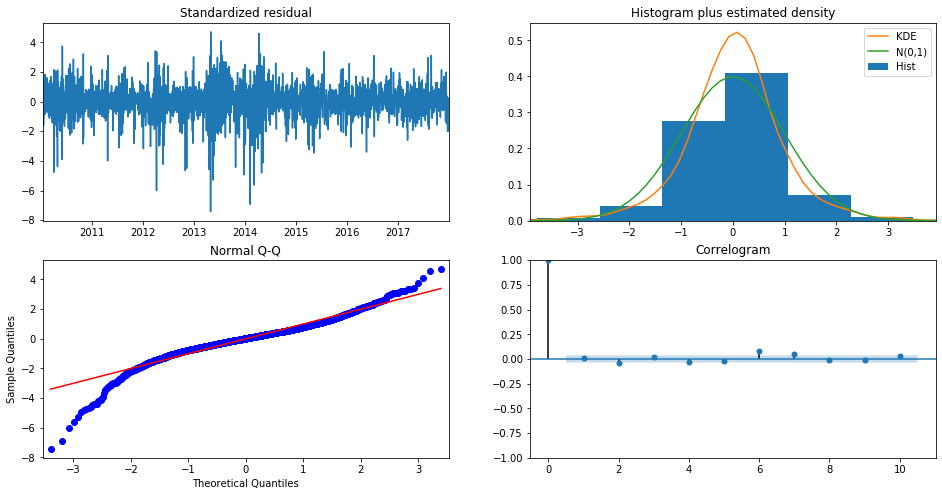

In [13]:
#vengono plottate le diagnostiche del modello, che confermano la bontà del modello trovato

model_sarima_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [14]:
log_train_time_series=log_train_time_series.tolist()
log_val_time_series=log_val_time_series.tolist()

In [15]:
#vengono istanziate le liste per la history del train e per le predizioni, inizialmente entrambe vuote
history_sarima_train=[]
predictions_sarima_train=[]

In [16]:
#viene eseguito un ciclo for nel quale viene istanziato un modello SARIMA, senza però essere ristimato (vengono
#utilizzati i parametri del modello fittato in precedenza). Ad ogni iterazione viene fatta una predizione, che 
#viene poi aggiunta alla lista delle predizioni. Successivamente viene aggiunta alla history il valore successivo
#delle serie storica e viene poi fatta la predizione successiva e così via.
#Lo stesso tipo di ragionamento viene applicato al modello UCM.

for i in range(len(log_train_time_series)):
    
    mod_sarima_train=SARIMAX(history_sarima_train,
                             order=(2,0,1),seasonal_order=(0,1,1,7),enforce_stationarity=False,
                             enforce_invertibility=False)
    res_sarima_train=mod_sarima_train.filter(model_sarima_fit.params)
    yhat_sarima_train = res_sarima_train.forecast()[0]
    predictions_sarima_train.append(yhat_sarima_train)
    history_sarima_train.append(log_train_time_series[i])

In [17]:
#viene calcolato l'rmse sul train set per il modello SARIMA

rmse_sarima_train=sqrt(mean_squared_error(log_train_time_series,predictions_sarima_train))

In [18]:
#vengono istanziate le liste per la history del validation set e per le predizioni, sempre sul validation set.
#Inizialmente la history viene con le osservazioni di tutto il train set

history_sarima_val = [x for x in log_train_time_series]
predictions_sarima_val=[]

In [19]:
#viene eseguito un ciclo for nel quale viene istanziato un modello SARIMA, senza però essere ristimato (vengono
#utilizzati i parametri del modello fittato in precedenza). Ad ogni iterazione viene fatta una predizione, che poi
#viene aggiunta sia alla lista delle predizioni, sia alla history della validation. Questo processo viene eseguito per tutta la lunghezza del 
#validation set. Questo processo viene ripetuto in maniera simile anche per il modello UCM

for i in range(len(log_val_time_series)):
    
    mod_sarima_val=SARIMAX(history_sarima_val,
                             order=(2,0,1),seasonal_order=(0,1,1,7),enforce_stationarity=False,
                             enforce_invertibility=False)
    res_sarima_val=mod_sarima_val.filter(model_sarima_fit.params)
    yhat_sarima_val = res_sarima_val.forecast()[0]
    predictions_sarima_val.append(yhat_sarima_val)
    history_sarima_val.append(yhat_sarima_val)

In [20]:
#viene calcolato l'rmse sul validation set per il modello SARIMA

rmse_sarima_val=sqrt(mean_squared_error(log_val_time_series,predictions_sarima_val))

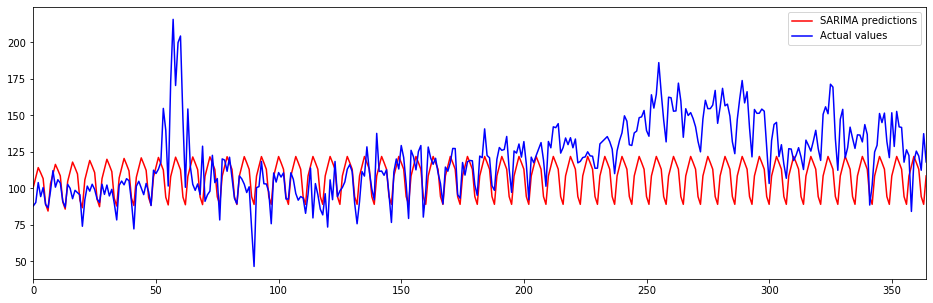

In [21]:
plt.figure(figsize=(16,5))
plt.plot(np.exp(predictions_sarima_val),color='red',label="SARIMA predictions")
plt.plot(np.exp(log_val_time_series),color='blue',label="Actual values")
plt.legend()
plt.autoscale(enable=True,axis='x',tight=True)

### MODELLO UCM

In [22]:
#vengono impostati i parametri del modello UCM, usando come componente di trend il random_walk e come componente
#stagionale una dummy con periodo 7.

model_params_ucm = {'level': 'random walk','seasonal':7}

In [23]:
#viene istanziato e poi fittato il modello UCM.

model_ucm = sm.tsa.UnobservedComponents(log_train_time_series, **model_params_ucm)
res_ucm = model_ucm.fit(method='powell', disp=False)

In [24]:
print(res_ucm.summary())

                           Unobserved Components Results                            
Dep. Variable:                            y   No. Observations:                 2922
Model:                          random walk   Log Likelihood                1166.662
                   + stochastic seasonal(7)   AIC                          -2329.325
Date:                      Fri, 10 Jan 2020   BIC                          -2317.369
Time:                              00:57:13   HQIC                         -2325.018
Sample:                                   0                                         
                                     - 2922                                         
Covariance Type:                        opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level        0.0205      0.000     52.670      0.000       0

In [25]:
#in questo chuck e nel successivo viene applicato lo stesso ragionamento fatto precedentemente con il train set
#del modello SARIMA.

history_ucm_train = []
predictions_ucm_train=[]

In [26]:
for i in range(len(log_train_time_series)):
    
    mod_ucm_train=sm.tsa.UnobservedComponents(history_ucm_train, **model_params_ucm)
    res_ucm_train=mod_ucm_train.filter(res_ucm.params)
    yhat_ucm_train =res_ucm_train.forecast()[0]
    predictions_ucm_train.append(yhat_ucm_train)
    history_ucm_train.append(log_train_time_series[i])

In [27]:
#viene calcolato l'rmse sul train set per il modello UCM

rmse_ucm_train=sqrt(mean_squared_error(log_train_time_series,predictions_ucm_train))

In [28]:
#in questo chuck e nel successivo viene applicato lo stesso ragionamento fatto precedentemente con il validation 
#set del modello SARIMA.

history_ucm_val = [x for x in log_train_time_series]
predictions_ucm_val=[]

In [29]:
for i in range(len(log_val_time_series)):
    
    mod_ucm_val=sm.tsa.UnobservedComponents(history_ucm_val, **model_params_ucm)
    res_ucm_val=mod_ucm_val.filter(res_ucm.params)
    yhat_ucm_val =res_ucm_val.forecast()[0]
    predictions_ucm_val.append(yhat_ucm_val)
    history_ucm_val.append(yhat_ucm_val)

In [30]:
#viene calcolato l'rmse sul validation set per il modello UCM

rmse_ucm_val=sqrt(mean_squared_error(log_val_time_series,predictions_ucm_val))

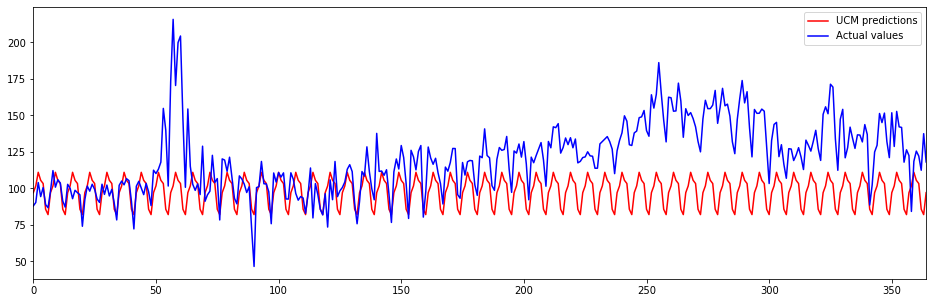

In [31]:
plt.figure(figsize=(16,5))
plt.plot(np.exp(predictions_ucm_val),color='red',label="UCM predictions")
plt.plot(np.exp(log_val_time_series),color='blue',label="Actual values")
plt.legend()
plt.autoscale(enable=True,axis='x',tight=True)

### RECURRENT NEURAL NETWORK: GRU

In [32]:
all_data=df["value"].values

In [33]:
test_data_size=365

train_data=all_data[:-test_data_size]
test_data=all_data[-test_data_size:]

In [34]:
train_data=np.log(train_data)
test_data=np.log(test_data)

In [35]:
scaler=MinMaxScaler()
train_data_normalized=scaler.fit_transform(train_data.reshape(-1,1))

In [36]:
#viene definita una finestra di train, ovvero il numero di "ritardi" da considerare per poter fittare la rete 
#neurale ricorrente

train_window=365

In [37]:
#funzione per poter creare sequenze di questo tipo: si prendono 365 giorni (train_seq) per poter prevedere 
#il 366esimo (train_label). Tra una sequenza ed un'altra c'è uno shift di un'unità.

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [38]:
#vengono create le sequenze di training

train_inout_seq=create_inout_sequences(train_data_normalized,train_window)

In [39]:
#viene costruito il modello di rete neurale ricorrente

def build_model(look_back):
    model = Sequential()
    model.add(GRU(128, input_shape=(1,look_back)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [40]:
#viene istanziato il modello

model=build_model(365)

In [41]:
#viene allenata la rete neurale, con 15 epoche di training

n_epochs=15

for i in range(n_epochs):
    for seq,labels in train_inout_seq:
        model.fit(seq.reshape(1,1,365),labels,epochs=1,shuffle=False,verbose=0)

In [42]:
#in questo chunk e nei due successivi, vengono fatte le predizioni sul train set

train_pred=len(train_data)

In [43]:
#lista a cui aggiungere le predizioni sul train set

train_inputs=train_data_normalized[:train_window].tolist()

In [44]:
#ad ogni iterazione viene aggiunta la predizione alla lista delle predizioni del train set

for i in range(train_pred):
    seq_gru_train=np.array(train_inputs[-train_window:])
    predictions_gru_train=model.predict(seq_gru_train.reshape(1,1,365))
    train_inputs.append(predictions_gru_train)

In [45]:
#le predizioni sul train set vengono riportate al loro valore originale

actual_predictions_gru_train=scaler.inverse_transform(np.array(train_inputs[train_window:]).reshape(-1,1))

In [46]:
#viene calcolato l'rmse sul train set per la rete neurale ricorrente

rmse_gru_train=sqrt(mean_squared_error(train_data,actual_predictions_gru_train))

In [47]:
#in questo chunk e nei due successivi, vengono fatte le predizioni sul validation set

future_pred=365

In [48]:
#lista a cui aggiungere le predizioni sul validation set

test_inputs=train_data_normalized[-train_window:].tolist()

In [49]:
#ad ogni iterazione viene aggiunta la predizione alla lista delle predizioni del validation set

for i in range(future_pred):
    seq_gru_val=np.array(test_inputs[-train_window:])
    predictions_gru_val=model.predict(seq_gru_val.reshape(1,1,365))
    test_inputs.append(predictions_gru_val)

In [50]:
#le predizioni sul validation set vengono riportate al loro valore originale

actual_predictions_gru_val=scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

In [51]:
#viene calcolato l'rmse sul validation set per la rete neurale ricorrente

rmse_gru_val=sqrt(mean_squared_error(test_data,actual_predictions_gru_val))

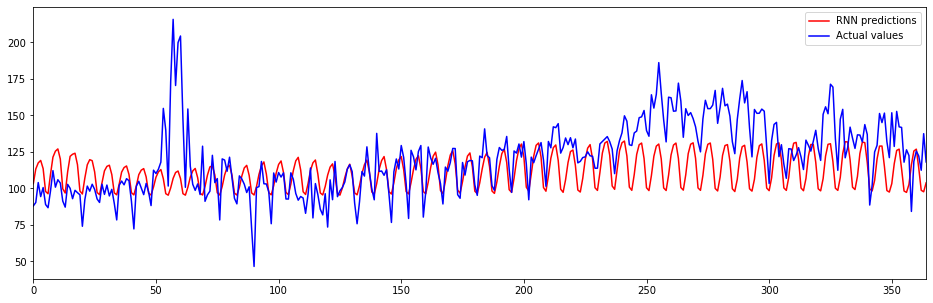

In [52]:
plt.figure(figsize=(16,5))
plt.plot(np.exp(actual_predictions_gru_val),color='red',label="RNN predictions")
plt.plot(np.exp(test_data),color='blue',label="Actual values")
plt.legend()
plt.autoscale(enable=True,axis='x',tight=True)

In [53]:
#viene costruito un dataframe per poter comparare, per ogni modello, gli RMSE, sia per il train set che per il
#validation set

error_data=[["SARIMA",rmse_sarima_train,rmse_sarima_val],["UCM",rmse_ucm_train,rmse_ucm_val],
            ["GRU",rmse_gru_train,rmse_gru_val]]

In [54]:
table=pd.DataFrame(error_data,columns=["Model","Train Error","Validation Error"])

In [55]:
table 

,Model,Train Error,Validation Error
0,SARIMA,0.176242,0.211045
1,UCM,0.215026,0.270935
2,GRU,0.291678,0.190428


In [56]:
#per effettuare le previsioni per il periodo temporale 1/1/2019-30/11/2019, vengono riallenati tutti i modelli
#usando tutto il dataset a disposizione, sempre secondo il ragionamento esposto precedentemente quando si sono
#effettuate le predizioni sul validation set.

In [57]:
df_all=df['2010-01-01':'2018-12-31']
total_values=df_all["value"]
total_values_log=np.log(total_values)

In [58]:
#### predizioni per SARIMA

In [59]:
history_sarima_all=[x for x in total_values_log]
predictions_2019_sarima=[]

In [60]:
for i in range(334):
    
    mod_sarima_all=SARIMAX(history_sarima_all,order=(2,0,1),seasonal_order=(0,1,1,7),
                           enforce_stationarity=False,enforce_invertibility=False)
    res_sarima_all=mod_sarima_all.filter(model_sarima_fit.params)
    yhat_sarima_all = res_sarima_all.forecast()[0]
    predictions_2019_sarima.append(yhat_sarima_all)
    history_sarima_all.append(yhat_sarima_all)

In [61]:
#### predizioni per UCM

In [62]:
history_ucm_all=[x for x in total_values_log]
predictions_2019_ucm=[]

In [63]:
for i in range(334):
    
    mod_ucm_all=sm.tsa.UnobservedComponents(history_ucm_all, **model_params_ucm)
    res_ucm_all=mod_ucm_all.filter(res_ucm.params)
    yhat_ucm_all =res_ucm_all.forecast()[0]
    predictions_2019_ucm.append(yhat_ucm_all)
    history_ucm_all.append(yhat_ucm_all)

In [64]:
#### predizioni per GRU

In [65]:
total_values_log=np.array(total_values_log)
total_values_log_normalized=scaler.fit_transform(total_values_log.reshape(-1,1))

In [66]:
prediction_sequence=create_inout_sequences(total_values_log_normalized,train_window)

In [67]:
prediction_model=build_model(365)

In [68]:
n_epochs=15

for i in range(n_epochs):
    for seq,labels in prediction_sequence:
        prediction_model.fit(seq.reshape(1,1,365),labels,epochs=1,shuffle=False,verbose=0)

In [69]:
pred_2019_lstm=334

In [70]:
prediction_inputs=total_values_log_normalized[-train_window:].tolist()

In [71]:
for i in range(pred_2019_lstm):
    seq_gru_all=np.array(prediction_inputs[-train_window:])
    prediction_gru_all=prediction_model.predict(seq_gru_all.reshape(1,1,365))
    prediction_inputs.append(prediction_gru_all)

In [72]:
predictions_2019_gru=scaler.inverse_transform(np.array(prediction_inputs[train_window:]).reshape(-1,1))

In [73]:
predictions_2019_gru=predictions_2019_gru.tolist()

In [74]:
#vengono create le date da inserire nel file csv e successivamente, per ogni modello, vengono inserite in un 
#dataframe le predizioni per il periodo in questione. Infine, il dataframe viene scritto in un file csv.

In [75]:
dates=pd.date_range(start="1/1/2019",end="30/11/2019")

In [76]:
dates=dates.tolist()

In [77]:
true_dates=[]

for date in dates:
    true_dates.append(str(date).split(" ")[0])

In [78]:
final_predictions_2019=[]

In [79]:
temp_pred=[]

for i in range(len(true_dates)):
    temp_pred.append(true_dates[i])
    temp_pred.append(np.exp(predictions_2019_sarima[i]))
    temp_pred.append(np.exp(predictions_2019_ucm[i]))
    temp_pred.append(np.exp(predictions_2019_gru[i][0]))
    final_predictions_2019.append(temp_pred)
    temp_pred=[]

In [80]:
prediction_table=pd.DataFrame(final_predictions_2019,columns=["Data","ARIMA","UCM","ML"])

In [81]:
prediction_table.to_csv("/home/davide/Scrivania/SDMTSA_848013_0.csv",index=False,sep=",")